<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EB%82%A8%EC%83%81%EC%9A%B0_%EC%9E%84%EC%8B%9C%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
# # 설치 후 런타임 재시작 할 것
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !pip install --upgrade matplotlib

In [3]:
!pip install -U sentence-transformers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
import torch.nn as nn
from torch import optim
from torch import optim

import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = "/content/drive/MyDrive/project_final/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 데이터 불러오기

In [7]:
pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv").head(3)

,review,reply,sentiment
0,"맛이 별로였어요, 조리 상태도 별로였고 배달 시간도 오래 걸렸네요","안녕하세요~! 맛이 별로였다고 하셨는데, 제 기준에는 싱겁고 딱히 맛있어 보이지 않...",0
1,양도 많고 맛나요,하핫 정말 이런 이런 칭찬에 춤추고 싶네요 든든한 생각나실 때 또 만나요 친절한 고...,1
2,음식의 퀄리티가 낮아서 별로였어요. 맛이 없어서 실망했어요,음식의 퀄리티가 낮아서 실망하셨다니 정말 죄송합니다. 더 맛있는 음식으로 만족스러운...,0


In [8]:
train = pd.read_csv(f"{DATA_PATH}service1_9000_9000.csv")
train.isnull().sum()

review       0
reply        0
sentiment    0
dtype: int64

In [9]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0    9205
1    9205
Name: sentiment, dtype: int64

### 단문 데이터 제거
- 데이터 정제 과정에서 무의미해진 데이터는 학습데이터로 사용불가
    - 리뷰 : 공백만 생겼거나, 리뷰 이벤트를 위한 단답형 제거

In [10]:
train[(train['review'].str.len() > 4) & (train['review'].str.len() <= 10)] # 리뷰

,review,reply,sentiment
1,양도 많고 맛나요,하핫 정말 이런 이런 칭찬에 춤추고 싶네요 든든한 생각나실 때 또 만나요 친절한 고...,1
166,맛있어요 와플 추천,추천해 주셔서 감사합니다 맛있다는 말씀은 언제 들어도 설레는 것 같습니다 더욱더 연...,1
251,정말 맛있었습니다,주문을 통해 한걸음 가까워진 것 같아 기분이 좋아요 1 고객을 생각하는 마음 2 더...,1
256,맛있어서 2번 시킴,감사합니다 항상 좋은 재료로 음식을 만들겠습니다 안심하셔도 됩니다 더 좋은 모습으로...,1
357,양도 많고 맛있어요,좋은 재료를 사용하고 고객님께 좋은 평가 들으며 행복을 느낍니다 고객님들 맛있게 드...,1
...,...,...,...
18150,맛있게 먹었습니다,저희 항정살 맛있게 잘 드시고 소중한 리뷰도 남겨 주셔서 너무 기쁘고 보람됩니다 저...,1
18164,맛있어요 괜찮아요,건강한 한 끼 저렴하지만 맛있게 만들겠습니다 저희 찾아주셔서 감사합니다,1
18178,맛이 너무 없어요.,불편을 드려 대단히 죄송합니다. 귀중한 의견 감사드립니다.,0
18197,맛있어요 2번째임,감사합니다 부탁드려요 진심으로 밈 맘에 들었다면 찜 부탁드립니다,1


In [11]:
train[(train['review'].str.len() > 4) & (train['review'].str.len() <= 10)] # 리뷰

,review,reply,sentiment
1,양도 많고 맛나요,하핫 정말 이런 이런 칭찬에 춤추고 싶네요 든든한 생각나실 때 또 만나요 친절한 고...,1
166,맛있어요 와플 추천,추천해 주셔서 감사합니다 맛있다는 말씀은 언제 들어도 설레는 것 같습니다 더욱더 연...,1
251,정말 맛있었습니다,주문을 통해 한걸음 가까워진 것 같아 기분이 좋아요 1 고객을 생각하는 마음 2 더...,1
256,맛있어서 2번 시킴,감사합니다 항상 좋은 재료로 음식을 만들겠습니다 안심하셔도 됩니다 더 좋은 모습으로...,1
357,양도 많고 맛있어요,좋은 재료를 사용하고 고객님께 좋은 평가 들으며 행복을 느낍니다 고객님들 맛있게 드...,1
...,...,...,...
18150,맛있게 먹었습니다,저희 항정살 맛있게 잘 드시고 소중한 리뷰도 남겨 주셔서 너무 기쁘고 보람됩니다 저...,1
18164,맛있어요 괜찮아요,건강한 한 끼 저렴하지만 맛있게 만들겠습니다 저희 찾아주셔서 감사합니다,1
18178,맛이 너무 없어요.,불편을 드려 대단히 죄송합니다. 귀중한 의견 감사드립니다.,0
18197,맛있어요 2번째임,감사합니다 부탁드려요 진심으로 밈 맘에 들었다면 찜 부탁드립니다,1


In [12]:
len(train[train['review'].str.len() <= 10])

269

In [13]:
train = train[train['review'].str.len() > 10]
train

,review,reply,sentiment
0,"맛이 별로였어요, 조리 상태도 별로였고 배달 시간도 오래 걸렸네요","안녕하세요~! 맛이 별로였다고 하셨는데, 제 기준에는 싱겁고 딱히 맛있어 보이지 않...",0
2,음식의 퀄리티가 낮아서 별로였어요. 맛이 없어서 실망했어요,음식의 퀄리티가 낮아서 실망하셨다니 정말 죄송합니다. 더 맛있는 음식으로 만족스러운...,0
3,리뷰가 좋아서 주문했는데 정말 맛있게 잘 먹었습니다 다 맛있어요 김밥 완전 빅 사이...,감사합니다 언제나 푸짐한 양과 맛있는 맛으로 찾아뵙겠습니다 자주 애용해 주세요,1
4,항상 맛있게 잘 먹고 있습니다,고객님 소중한 고객님이 이임 항상 찾아주시고 맛있게 드셔주시니 너어어어무 기쁘고 행...,1
5,음식이 맛이 없어서 좀 아쉬웠어요. 다음에는 다른 음식점에서 시켜야겠어요,저희 음식이 맛이 없어서 아쉬움을 드렸군요. 다음에는 고객님께 맛있는 음식을 제공할...,0
...,...,...,...
18405,친구시켜줬는데 사진은 이렇지만 고기 많고 맛있대요 감사합니다,저희 매장을 빛내 주셔서 영광 맛깔나는 사진 너무 감사해요 맛있게 드셔 주시기만 해...,1
18406,맛있게 먹는 단골집,자주자주 찾아주세요 저희 이용해 주셔서 감사합니다 최고보다는 최선을 다하는 될 수 ...,1
18407,가격이 좀 비싸서 아쉬웠어요. 좀 더 저렴하면 좋겠어요,가격이 비싸셨다니 정말 죄송합니다. 고객님의 의견을 반영하여 가격을 조정할 수 있도...,0
18408,센스가 없는 배달이었어요.,다음에는 더욱더 만족스러운 서비스를 제공하기 위해 노력하겠습니다.,0


## 긍부정 데이터 비율 선택

In [14]:
train['sentiment'].value_counts().sort_index() # 긍부정 분포 확인

0    9183
1    8958
Name: sentiment, dtype: int64

In [15]:
train_neg = train[train['sentiment'] == 0]

# 긍정 데이터 중 중복된 답변제거
train_pos = train[train['sentiment'] == 1].drop_duplicates(subset='reply', keep=False)
train_pos['sentiment'].value_counts().sort_index()

1    8958
Name: sentiment, dtype: int64

In [16]:
# 긍정 데이터를 랜덤으로 추출하기 위해 섞기
shuffled_train_pos = train_pos.sample(frac=1, random_state=42)
shuffled_train_neg = train_neg.sample(frac=1, random_state=42)

train_pos = shuffled_train_pos.iloc[:50].reset_index(drop=True)
train_neg = shuffled_train_neg.iloc[:50].reset_index(drop=True)

# 데이터 합치기
train = pd.concat([train_neg, train_pos], ignore_index=True)
train['sentiment'].value_counts().sort_index()

0    50
1    50
Name: sentiment, dtype: int64

In [17]:
# 다시 섞기
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train

,review,reply,sentiment
0,맛있게 잘 먹었습니다 양도 1인분 같지 않게 많고요 배달로 빨리 왔습니다 반찬도 메...,안녕하세요 푸짐하고 맛있는 맛있게 잘 드셔주신 것 같아 기분 좋습니다 히히 다음에 ...,1
1,오늘도 역시나 맛있게 잘 먹었습니다,헤헤헤헿 엄지 척 너무 좋아하는 엄지 척 앞으로도 더욱 열심히 만들어볼게요 앞으로도...,1
2,정말 맛있게 먹었습니다,맛있게 드셨다니 감사합니다 새해 첫 월요일 시작 잘하시고 늘 행복하세요,1
3,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,안녕하세요. 줄어드는 음식의 양과 맛에 대해 불만을 표시해주셨군요. 이는 매우 안타...,0
4,"맛있게 먹을 수 있나 기대하고 주문했는데, 별로였어요. 아쉬웠습니다",맛있게 먹을 수 없는 경험을 제공한 점 깊이 반성하고 있습니다. 다음에는 보다 개선...,0
...,...,...,...
95,양 엄청 많아서 좋아요,대부분의 ICE 음료를 1리터 대용량 사이즈로 즐길 수 있는 건 저희 봄봄만의 엄청...,1
96,처음 시켜 먹어봤는데 양도 많고 서비스도 좋고 좋아요 자주 시켜 먹을 거 같아요,첫 주문에 고객님 만족드리기 대 성공했나 유 자주 찾아주시면 저는 자주자주 행복할 ...,1
97,별로 맛있지 않았고 배송이 늦어서 식어서 먹기도 그렇게 좋지 않았어요.,"안녕하세요, 상추가 상한 것 같아 정말 죄송합니다. 저희는 항상 신선한 재료를 사용...",0
98,양도 많고 맛있게 잘 먹었습니다 어묵탕도 진짜 많이 주셨어요,맛있게 드시고 칭찬글로 응원해 주시니 저희도 기분이 가득 오늘 하루도 감사드리며 다...,1


# 유사도 확인

## 유사도 군집화 라벨 불러오기

In [18]:
pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

,label
0,맛이 없어요
1,양이 적어요
2,배달이 느려요
3,맛은 있는데 양이 적어요
4,맛은 있는데 배달이 느려요
5,양은 많은데 맛이 없어요
6,배달은 빠른데 맛이 없어요
7,양은 많은데 배달이 느려요
8,배달은 빠른데 양이 적어요
9,맛있어요


In [19]:
sim_cluster_label = pd.read_csv(f"{DATA_PATH}sim_cluster_label.csv")

In [20]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
bert_model = SentenceTransformer('jhgan/ko-sroberta-multitask')

def evaluate_similarity(label_text, review_text, alpha=0.9): # cosine 가중치 조절
    label_embedding = bert_model.encode(label_text)
    review_embedding = bert_model.encode(review_text)

    # 코사인 유사도
    cosine_sim = 1 - pairwise_distances([label_embedding], [review_embedding], metric='cosine')[0][0]

    # 자카드 유사도
    label_tokens = set(label_text.split())
    review_tokens = set(review_text.split())
    jaccard_sim = len(label_tokens.intersection(review_tokens)) / len(label_tokens.union(review_tokens))

    # 가중 평균 내보기
    weighted_sim = alpha*cosine_sim + (1 - alpha)*jaccard_sim

    return weighted_sim

In [21]:
result = []
for label in tqdm(sim_cluster_label['label']):
    for review in train['review']:
        score = evaluate_similarity(label, review)
        if score >= 0.5:
            result.append({'label': label, 'review': review, 'score': score})

result = pd.DataFrame(result)
result

  0%|          | 0/12 [00:00<?, ?it/s]

,label,review,score
0,맛이 없어요,해산물이 상태가 좋지 않고 맛도 별로에요. 깔끔하지 않고 별로였습니다.,0.559386
1,맛이 없어요,맛이 싱겁고 별로였어요,0.623185
2,맛이 없어요,맛이 전혀 좋지 않았어요. 다른 음식점을 찾아봐야겠어요,0.519947
3,맛이 없어요,재료가 너무 많아서 오히려 맛이 무색해진 것 같아요. 정말 실망이에요.,0.535901
4,맛이 없어요,비주얼은 괜찮았는데 맛이 별로였어요.,0.555155
...,...,...,...
132,양이 많아요,양 엄청 많아서 좋아요,0.783150
133,양이 많아요,양도 많고 맛있게 잘 먹었습니다 어묵탕도 진짜 많이 주셨어요,0.536729
134,배달이 빨라요,맛도 좋고 배달도 빠르고 좋아요,0.714499
135,배달이 빨라요,배달도 빠르고 맛있어요,0.799815


In [22]:
# result.to_csv('result.csv', index=False, encoding = "utf-8-sig")

# # 엑셀로 확인
# with pd.ExcelWriter("result.xlsx", engine='openpyxl') as writer:
#     result.to_excel(writer, sheet_name='시트1', index=False)

In [23]:
label_counts = result['label'].value_counts()
label_counts

양은 많은데 맛이 없어요     29
맛있어요              29
맛이 없어요            15
맛은 있는데 배달이 느려요    15
배달은 빠른데 맛이 없어요    13
맛은 있는데 양이 적어요     10
양은 많은데 배달이 느려요     7
양이 많아요             7
배달이 느려요            5
배달이 빨라요            3
양이 적어요             2
배달은 빠른데 양이 적어요     2
Name: label, dtype: int64

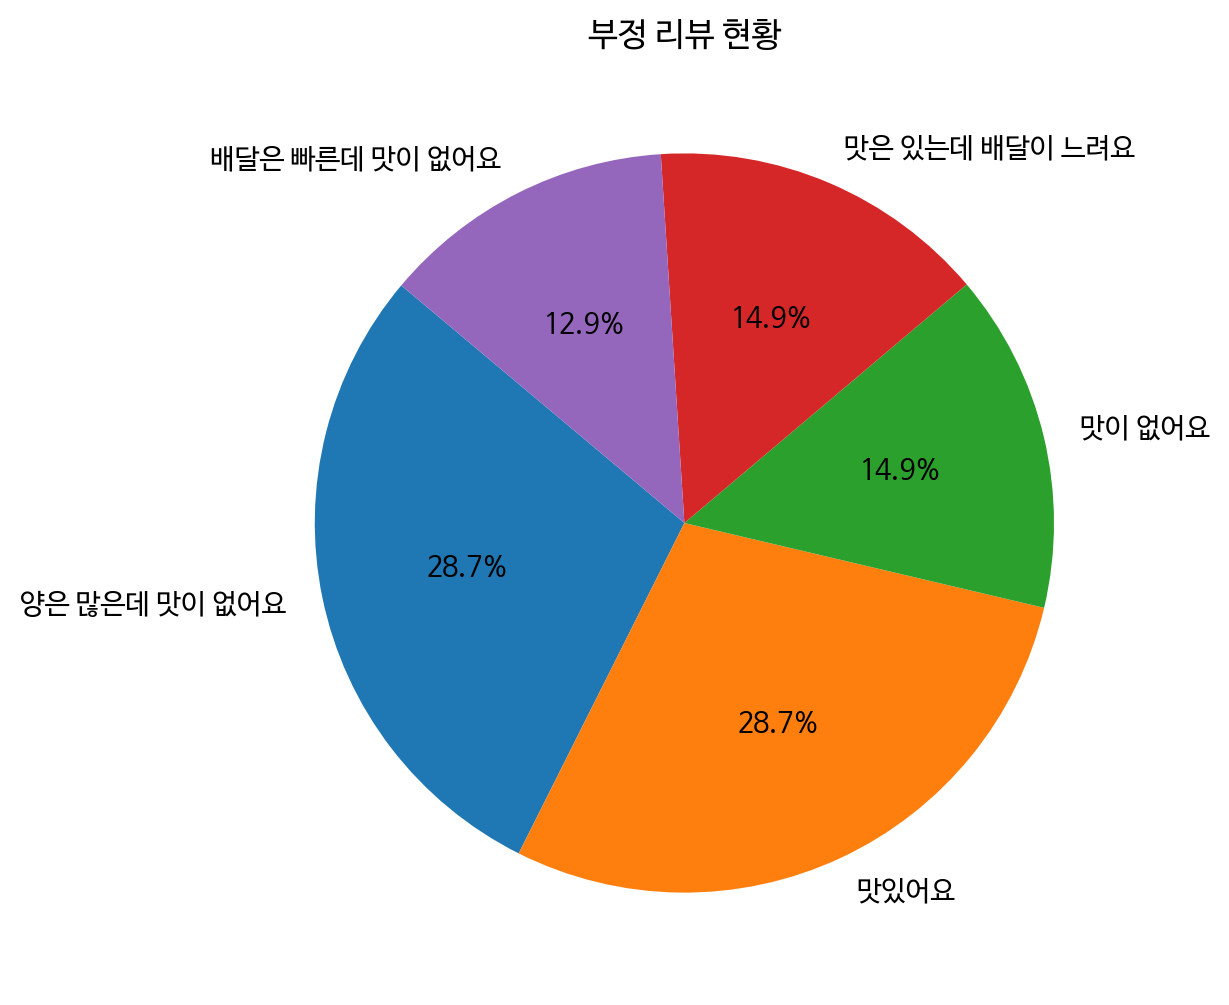

In [24]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='NanumBarunGothic')

plt.figure(figsize=(6, 6))
plt.pie(label_counts[:5], labels=label_counts[:5].index, autopct='%1.1f%%', startangle=140)
plt.title('부정 리뷰 현황')
plt.show()